Enter the file path for the annotation file: D:\MELA\ANNOTATION ANALYSIS\20230310_SM_Lek1_P1D1_DJI_0158.csv
Frames with classid errors: [ 744 1892 2103]
classid_error_statements: ['Frame 744 = (9), (1), (6), (5), (3), (8), (4), (13), (17), (0), (11), (2), (14), (12), (10), (16), (7), (15)', 'Frame 1892 = (14), (1), (42), (19), (29), (25), (11), (39), (9), (5), (31), (3), (8), (4), (44), (12), (27), (21), (41), (23), (6), (38), (20), (43), (26), (30), (40), (0), (32), (7), (15), (36), (34), (22), (28), (18), (35), (17), (24), (33), (2), (37), (10), (16)', 'Frame 2103 = (42), (41), (31), (20), (18), (43), (19), (44), (11), (15), (14), (12), (7), (16)']
Frames with Duplicates: [ 126  127 1892]
ID 13 (Class 0) has IOU value 0 between the frames 2611 and 2612
ID 45 (Class 0) has IOU value 0 between the frames 1788 and 1789
ID 4 (Class 1) has IOU value 0 between the frames 1810 and 1811
ID 18 (Class 1) has IOU value 0 between the frames 601 and 602
ID 20 (Class 1) has IOU value 0 between the

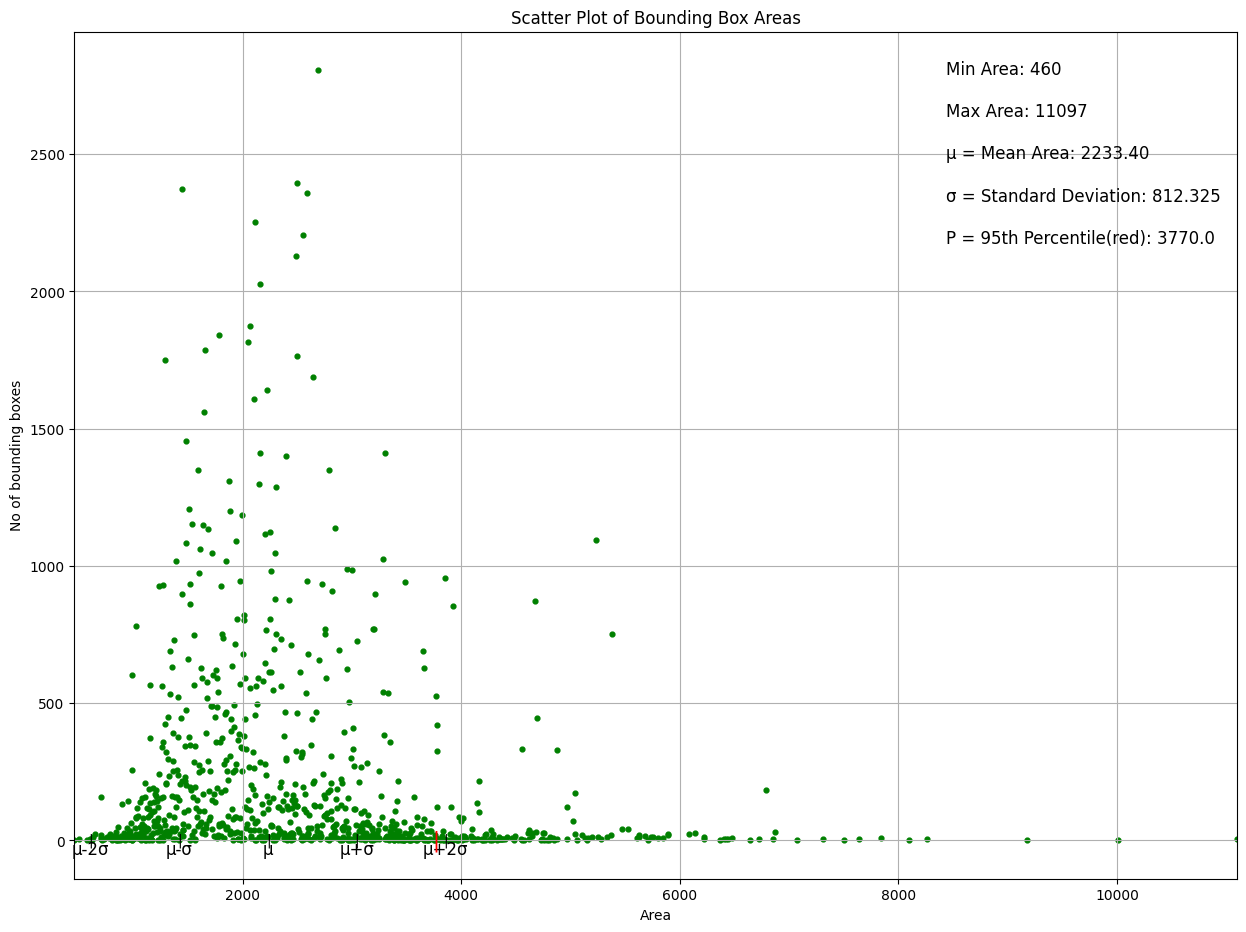

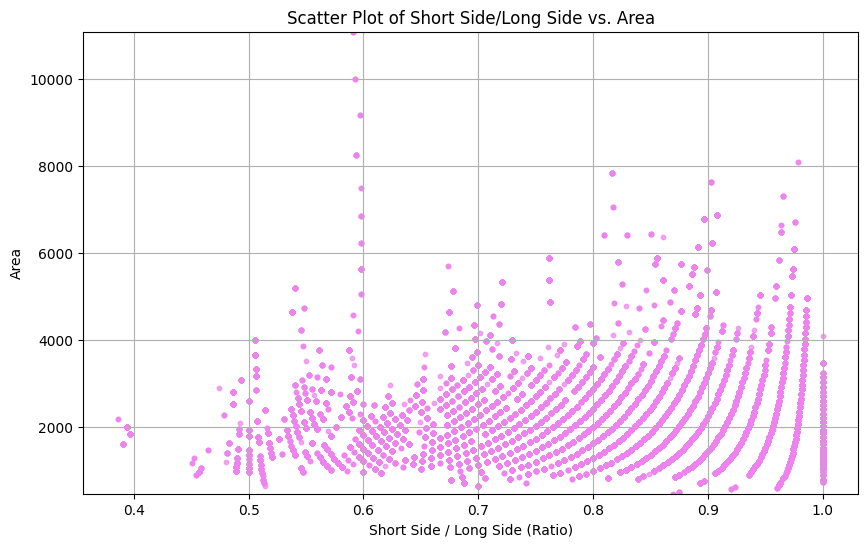

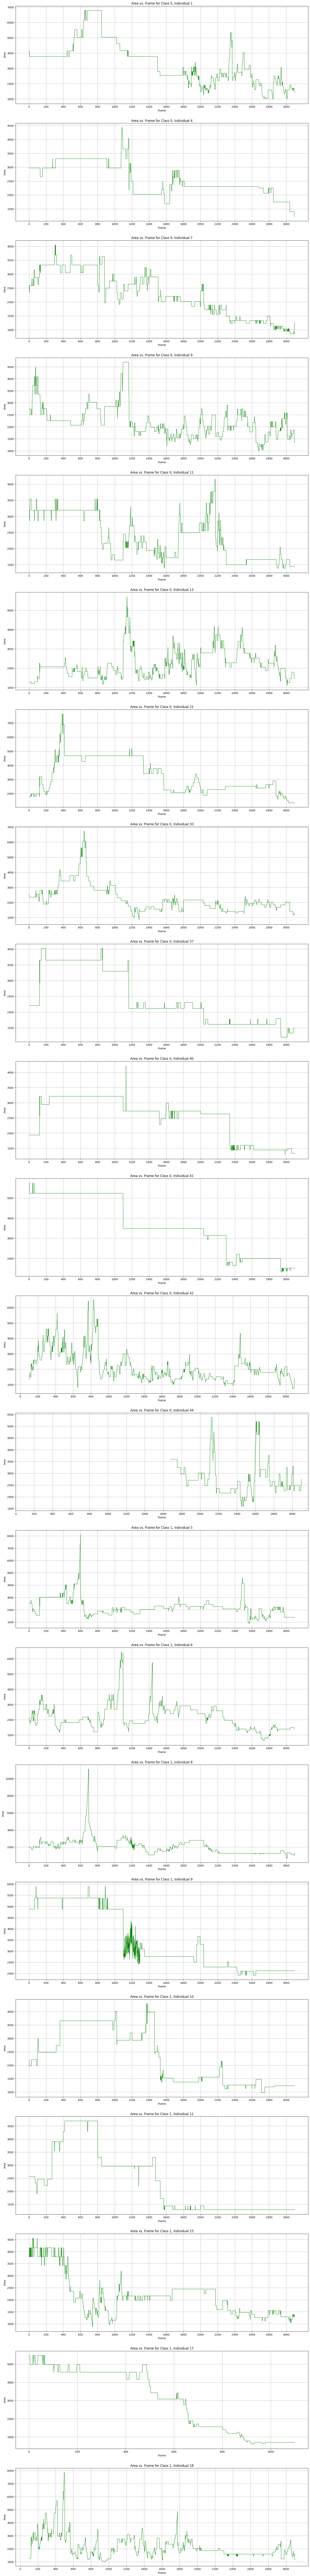

In [3]:
#Author : Dipin
#Function : Analyse the annotation file to produce text, csv,and graphs


import os
import pandas as pd
import math
import matplotlib.pyplot as plt

def main():
    csv_file_path = input("Enter the file path for the annotation file: ")
    df, unique_frames_count, total_individuals, unique_individuals, csv_file_name, input_directory = process_csv(csv_file_path)
    df, frames_with_classid_error, box_classid_error, classid_error_statements = class_error(df)
    df, frames_with_duplicates, duplicate_statements = duplicates(df)
    df, sentences_iou, row_with_iou_0 = iou(df)
    total_individuals_area,  unique_individuals_area, frames_unique_entries_area, total_individuals_area, statements_area = area_analysis(df)
    filtered_disappearance_statements = disappearing_boxes(df, frames_with_classid_error, frames_with_duplicates)
    plot1(df, input_directory, csv_file_name)
    create_individual_plots(df, unique_individuals_area, total_individuals_area, input_directory, csv_file_name)
    csv_file_path = save_dataframe_to_csv(df, csv_file_path)
    text_save(
        input_directory,
        csv_file_name,
        frames_with_classid_error,
        frames_with_duplicates,
        frames_unique_entries_area,
        total_individuals_area,
        unique_frames_count,
        unique_individuals,
        statements_area,
        filtered_disappearance_statements,
        sentences_iou,
        row_with_iou_0,
        box_classid_error,
        duplicate_statements,
        classid_error_statements 
    )
    

def process_csv(file_path):
    # Define the column headers
    headers = ['frame', 'classid', 'id', 'x1', 'y1', 'width', 'height', 'a', 'b', 'c', 'd']
    # Read the CSV file into a DataFrame and assign the headers
    df_in = pd.read_csv(file_path, header=None, names=headers)  
    input_directory = os.path.dirname(file_path)
    csv_file_name = os.path.splitext(os.path.basename(file_path))[0]
     # Find the number of unique frames in the 'frames' column
    unique_frames_count = df_in['frame'].nunique()
    # Get unique individuals
    unique_individuals = df_in[['classid', 'id']].drop_duplicates()
    # Remove entries with classid 2 or -1
    unique_individuals = unique_individuals[(unique_individuals['classid'] != 2) & (unique_individuals['classid'] != -1)]
    # Calculate the total number of unique individuals
    total_individuals = len(unique_individuals)
    # Calculate 'area' column
    df_in['area'] = df_in['width'] * df_in['height']
    return df_in, unique_frames_count, total_individuals, unique_individuals, csv_file_name, input_directory

    
#find classid 
def class_error(df_in):
    # Create a new column 'classid_error' and initialize it with 0
    df_in['classid_error'] = 0

    # Function to update 'classid_error' column based on 'classid' column
    def update_classid_error(row):
        if row['classid'] == -1:
            return 1
        else:
            return row['classid_error']

    # Apply the update_classid_error function to each row
    df_in['classid_error'] = df_in.apply(update_classid_error, axis=1)

    df_in['classid_error_frame'] = 0

    # Find frames with 'classid_error' entry of 1
    frames_with_classid_error = df_in[df_in['classid_error'] == 1]['frame'].unique()

    # Update 'classid_error_frame' column for the identified frames
    df_in.loc[df_in['frame'].isin(frames_with_classid_error), 'classid_error_frame'] = 1

    box_classid_error = df_in['classid_error'].sum()

    # Print frames with classid errors
    print("Frames with classid errors:", frames_with_classid_error)

    classid_error_statements = []
    for frame in frames_with_classid_error:

        classid_error_enteries = df_in[(df_in['frame'] == frame) & (df_in['classid_error'] == 1)]
        classid_id_pairs = set()  # Use a set to ensure unique pairs
        for index, row in classid_error_enteries.iterrows():
            classid_id_pairs.add(f"({row['id']})")
        statement = f"Frame {frame} = {', '.join(classid_id_pairs)}"
        classid_error_statements.append(statement)

    # Print frames with duplicates
    print("classid_error_statements:", classid_error_statements)

    return df_in, frames_with_classid_error, box_classid_error, classid_error_statements 




    #Finding duplicate frames
def duplicates(df_in):
    # Create a new column 'duplicates' indicating if a row is a duplicate
    df_in['duplicates'] = df_in.groupby(['frame', 'classid'])['id'].transform(lambda x: x.duplicated(keep=False).astype(int))
    duplicate_statements = []

    # Find unique frames with duplicates
    frames_with_duplicates = df_in.loc[df_in['duplicates'] == 1, 'frame'].unique()

    # Create 'duplicate_frame' column and set values based on 'frame' and 'frames_with_duplicates'
    df_in['duplicate_frame'] = df_in['frame'].apply(lambda x: 1 if x in frames_with_duplicates else 0)


    for frame in frames_with_duplicates:
        duplicate_entries = df_in[(df_in['frame'] == frame) & (df_in['duplicates'] == 1)]
        classid_id_pairs = set()  # Use a set to ensure unique pairs
        for index, row in duplicate_entries.iterrows():
            classid_id_pairs.add(f"({row['classid']}:{row['id']})")
        statement = f"Frame {frame} = {', '.join(classid_id_pairs)}"
        duplicate_statements.append(statement)

    # Print frames with duplicates
    print("Frames with Duplicates:", frames_with_duplicates)

    return df_in, frames_with_duplicates, duplicate_statements

def iou(df_in):    

    #intersection over union
     # Sort the DataFrame by 'classid', 'id', and 'frame' in ascending order
    df_in.sort_values(by=['classid', 'id', 'frame'], inplace=True)

    # Create a new column to store the IoU values
    df_in['iou'] = 0.0  # Initialize with zeros

    # Create a dictionary to store the last bounding box coordinates for each individual within each class
    last_bbox_dict = {}

    # Iterate through the DataFrame
    for index, row in df_in.iterrows():
        classid = row['classid']
        individual_id = row['id']
        frame = row['frame']
        x1 = row['x1']
        y1 = row['y1']
        width = row['width']
        height = row['height']

        # Check if the individual within a class was present in the previous frame
        if (classid, individual_id) in last_bbox_dict:
            last_x1, last_y1, last_width, last_height = last_bbox_dict[(classid, individual_id)]

            # Calculate the coordinates of the current bounding box
            x2 = x1 + width
            y2 = y1 + height

            # Calculate the coordinates of the last known bounding box
            last_x2 = last_x1 + last_width
            last_y2 = last_y1 + last_height

            # Calculate the intersection coordinates
            intersection_x1 = max(x1, last_x1)
            intersection_y1 = max(y1, last_y1)
            intersection_x2 = min(x2, last_x2)
            intersection_y2 = min(y2, last_y2)

            # Calculate the areas of the current and last bounding boxes
            area_current = (x2 - x1) * (y2 - y1)
            area_last = (last_x2 - last_x1) * (last_y2 - last_y1)

            # Calculate the area of intersection
            area_intersection = max(0, intersection_x2 - intersection_x1) * max(0, intersection_y2 - intersection_y1)

            # Calculate the IoU
            iou = area_intersection / (area_current + area_last - area_intersection)

            # Update the DataFrame with the calculated IoU
            df_in.at[index, 'iou'] = iou

        # Update the last bounding box coordinates for the individual within the class
        last_bbox_dict[(classid, individual_id)] = (x1, y1, width, height)

    #Finding boxes with IOU=0    
    row_with_iou_0 = df_in[(df_in['iou'] == 0) & (df_in['frame'] != df_in.groupby(['classid', 'id'])['frame'].transform('min')) & (df_in['classid'] != -1)]

    len(row_with_iou_0)

    # Initialize an empty list to store sentences
    sentences_iou = []

    # Iterate through the rows of row_with_iou_0 DataFrame
    for index, row in row_with_iou_0.iterrows():
        classid = int(row['classid'])
        id_value = int(row['id'])
        frame_start = int(row['frame'])
        frame_end = frame_start - 1  # Subtract 1 from frame_start

        # Create the sentence in the desired format
        sentence_iou = f'ID {id_value} (Class {classid}) has IOU value 0 between the frames {frame_end} and {frame_start}'


        # Append the sentence to the list
        sentences_iou.append(sentence_iou)

    # Print the sentences or save them as needed
    for sentence_iou in sentences_iou:
        print(sentence_iou)   


    return df_in, sentences_iou, row_with_iou_0


def disappearing_boxes(df_in, frames_with_classid_error, frames_with_duplicates):
    # Sort the DataFrame by 'id' and 'frame' in ascending order
    df_in.sort_values(by=['id', 'frame'], inplace=True)

    # Create a dictionary to store the last frame for each individual
    last_frame_dict = {}
    disappearance_statements = []  # Initialize a list to store disappearance statements

    # Iterate through the DataFrame
    for index, row in df_in.iterrows():
        classid = int(row['classid'])
        individual_id = int(row['id'])
        frame = int(row['frame'])

        # Check if the individual was present in the previous frame
        if (classid, individual_id) in last_frame_dict:
            last_frame = last_frame_dict[(classid, individual_id)]

            if frame != last_frame + 1:
                statement = f"ID {individual_id} (Class {classid}) disappeared in frame {last_frame} and reappeared in frame {frame}"
                disappearance_statements.append(statement)  # Collect the statements

        # Update the last frame for the individual
        last_frame_dict[(classid, individual_id)] = frame

    # Create a new list without entries containing 'Class -1' and not having one less of the numbers stored in 'frames_with_classid_error'
    filtered_disappearance_statements = [
        statement for statement in disappearance_statements 
        if 'Class -1' not in statement 
        and all(f"frame {frame - 1}" not in statement for frame in frames_with_classid_error)
        and all(f"frame {frame}" not in statement for frame in frames_with_duplicates)
    ]

    return filtered_disappearance_statements


def area_analysis(df_in):
    # Filter rows where 'area' is greater than 4000
    rows_with_high_area = df_in[df_in['area'] > 4000]
    statements_area = []
    frames_unique_high_area = rows_with_high_area[(rows_with_high_area['classid'] != -1) & (rows_with_high_area['classid'] != 2)]
    frames_unique_entries_area = frames_unique_high_area['frame'].nunique()

    # Print the number of unique entries
    print("Number of unique frames with area above 4000:", frames_unique_entries_area)

    # Get the unique combination of 'classid' and 'id' values for all individuals
    unique_individuals_area = rows_with_high_area[['classid', 'id']].drop_duplicates()

    unique_individuals_area = unique_individuals_area[(unique_individuals_area['classid'] != -1) & (unique_individuals_area['classid'] != 2)]

    # Calculate the total number of unique individuals
    total_individuals_area = len(unique_individuals_area)

    # Print the total number of unique individuals
    print("Total Number of Unique Individuals (Male and Female):", total_individuals_area)

    # Check if frames_unique_entries_area is greater than 0
    if frames_unique_entries_area > 0:
        # Create an empty DataFrame to store the results
        df_area = unique_individuals_area.copy()

        # Function to count frames where area > 4000 for an individual
        def count_frames_above_4000(classid, individual_id):
            filtered_df = df_in[(df_in['classid'] == classid) & (df_in['id'] == individual_id)]
            frames_above_4000 = len(filtered_df[filtered_df['area'] > 4000])
            return frames_above_4000

        # Apply the function to each row of df_area and store the result in a new column
        df_area['no of frames>4000'] = df_area.apply(lambda row: count_frames_above_4000(row['classid'], row['id']), axis=1)

        # Create an empty list to store the statements
        statements_area = []

        # Function to count frames where area > 4000 for an individual and generate statements
        def generate_statements(classid, individual_id):
            filtered_df = df_in[(df_in['classid'] == classid) & (df_in['id'] == individual_id)]
            frames_above_4000 = len(filtered_df[filtered_df['area'] > 4000])

            # Generate the statement and append it to the list
            statement = f"ID {individual_id} (Class {classid}) = {frames_above_4000} frames."
            statements_area.append(statement)

        # Apply the function to each row of df_area
        df_area.apply(lambda row: generate_statements(row['classid'], row['id']), axis=1)

        # Print the generated statements
        for statement in statements_area:
            print(statement)
    else:
        print("No unique entries found above threshold.")

    return total_individuals_area,  unique_individuals_area, frames_unique_entries_area, total_individuals_area, statements_area



def plot1(df_in, input_directory, csv_file_name):
    def calculate_percentile(df_in, column, percentile):
        df_in = df_in.sort_values(by=column)
        index = (len(df_in) - 1) * percentile
        floor_index = math.floor(index)
        ceil_index = math.ceil(index)
        if floor_index == ceil_index:
            return df_in.iloc[int(index)][column]
        else:
            floor_value = df_in.iloc[floor_index][column] 
            ceil_value = df_in.iloc[ceil_index][column]
            return floor_value + (ceil_value - floor_value) * (index - floor_index)

    # Filter the DataFrame to exclude rows where 'classid' is 2
    df_area_filtered = df_in[df_in['classid'] != 2]

    # Calculate the frequency of each area value
    area_counts = df_area_filtered['area'].value_counts().sort_index()

    # Extract area values and their frequencies
    area_values = area_counts.index
    frequencies = area_counts.values

    # Calculate the mean area
    mean_area = df_area_filtered['area'].mean()

    # Calculate the standard deviation of the area values
    std_dev_area = round(df_area_filtered['area'].std(), 3)

    # Calculate the values for mean + standard deviation and mean - standard deviation
    mean_plus_std = mean_area + std_dev_area
    mean_minus_std = mean_area - std_dev_area

    # Calculate the values for mean + 2*standard deviation and mean - 2*standard deviation
    mean_plus_2std = mean_area + 2 * std_dev_area
    mean_minus_2std = mean_area - 2 * std_dev_area

    # Finding the 95th percentile
    percentile = calculate_percentile(df_in, 'area', 0.95)

    # Create a scatter plot with green color
    plt.figure(figsize=(15, 11))  # Reduced figure size
    plt.scatter(area_values, frequencies, color="green", marker='o', s=12)
    plt.xlabel('Area')
    plt.ylabel('No of bounding boxes')
    plt.title('Scatter Plot of Bounding Box Areas')
    plt.grid()

    # Set the X-axis range to the minimum and maximum area values
    plt.xlim(min(area_values), max(area_values))

    # Annotate the plot with the lowest and highest area values
    plt.annotate(f'Min Area: {min(area_values)}', xy=(0.75, 0.95), xycoords='axes fraction', color='black', fontsize=12)
    plt.annotate(f'Max Area: {max(area_values)}', xy=(0.75, 0.9), xycoords='axes fraction', color='black', fontsize=12)
    plt.annotate(f'μ = Mean Area: {mean_area:.2f}', xy=(0.75, 0.85), xycoords='axes fraction', color='black', fontsize=12)
    plt.annotate(f'σ = Standard Deviation: {std_dev_area}', xy=(0.75, 0.8), xycoords='axes fraction', color='black', fontsize=12)
    plt.annotate(f'P = 95th Percentile(red): {percentile}', xy=(0.75, 0.75), xycoords='axes fraction', color='black', fontsize=12)

    # Place an asterisk precisely on the x-axis at the mean_area value
    plt.annotate('|', xy=(mean_area, 0), xycoords='data', color='black', fontsize=10, ha='center', va='center')
    plt.annotate('μ', xy=(mean_area, 0), xycoords='data', color='black', fontsize=12, ha='center', va='top')

    # Add annotations for mean + standard deviation and mean - standard deviation on the x-axis below the axis
    plt.annotate('μ+σ', xy=(mean_plus_std, 0), xycoords='data', color='black', fontsize=12, ha='center', va='top')
    plt.annotate('μ-σ', xy=(mean_minus_std, 0), xycoords='data', color='black', fontsize=12, ha='center', va='top')
    plt.annotate('|', xy=(mean_plus_std, 0), xycoords='data', color='black', fontsize=10, ha='center', va='center')
    plt.annotate('|', xy=(mean_minus_std, 0), xycoords='data', color='black', fontsize=10, ha='center', va='center')

    # Add annotations for mean + 2*standard deviation and mean - 2*standard deviation on the x-axis below the axis
    plt.annotate('μ+2σ', xy=(mean_plus_2std, 0), xycoords='data', color='black', fontsize=12, ha='center', va='top')
    plt.annotate('μ-2σ', xy=(mean_minus_2std, 0), xycoords='data', color='black', fontsize=12, ha='center', va='top')
    plt.annotate('|', xy=(mean_plus_2std, 0), xycoords='data', color='black', fontsize=10, ha='center', va='center')
    plt.annotate('|', xy=(mean_minus_2std, 0), xycoords='data', color='black', fontsize=10, ha='center', va='center')

    plt.annotate('|', xy=(percentile, 0), xycoords='data', color='red', fontsize=15, ha='center', va='center')

    # Save the plot to a file
    image_filename_scatter = os.path.join(input_directory, f'{csv_file_name}_area_scatter_plot.png')
    plt.savefig(image_filename_scatter, bbox_inches='tight', format='png')

    # Show the plot
    plt.show()


    #area vs aspect ratio
    df_inc=df_in.copy()
    # Calculate the ratio of short side to long side (width/height)
    df_inc['short_side'] = df_inc[['width', 'height']].min(axis=1)
    df_inc['long_side'] = df_inc[['width', 'height']].max(axis=1)
    df_inc['ratio'] = df_inc['short_side'] / df_inc['long_side']

    # Create a scatter plot with ratio on the x-axis and area on the y-axis
    plt.figure(figsize=(10, 6))
    plt.scatter(df_inc['ratio'], df_inc['area'], s=10, c='violet', alpha=0.7)

    # Add labels and title
    plt.xlabel('Short Side / Long Side (Ratio)')
    plt.ylabel('Area')
    plt.title('Scatter Plot of Short Side/Long Side vs. Area')

    # Show the plot
    plt.grid()
    # Set the X-axis range to the minimum and maximum area values
    plt.ylim(min(area_values), max(area_values))

    # Save the figure with a filename
    image_filename_aspect_ratio = os.path.join(input_directory, f'{csv_file_name}_Aspect_ratio_vs_area.png')
    plt.savefig(image_filename_aspect_ratio, bbox_inches='tight', format='png')
    plt.show()
    
    
# Function to plot graphs for individuals above 4000
def create_individual_plots(df_in, unique_individuals_area, total_individuals_area, input_directory, csv_file_name):
    if 50> total_individuals_area > 0:
        # Create a single figure to contain all plots
        fig, axes = plt.subplots(len(unique_individuals_area), 1, figsize=(20, 8 * len(unique_individuals_area)))

        for i, (_, row) in enumerate(unique_individuals_area.iterrows()):
            classid, individual_id = row['classid'], row['id']

            # Select the current subplot
            ax = axes[i]

            # Clear the previous plot from the subplot
            ax.clear()

            filtered_df = df_in[(df_in['classid'] == classid) & (df_in['id'] == individual_id)]
            grouped_df = filtered_df.groupby('frame')['area'].mean()

            ax.set_title(f'Area vs. Frame for Class {classid}, Individual {individual_id}')
            ax.set_xlabel('Frame')
            ax.set_ylabel('Area')

            # Plot the data points with a slight curve
            x = grouped_df.index
            y = grouped_df.values
            ax.plot(x, y, color='green', linestyle='-', linewidth=1)  # Adjust the linewidth for a thicker line

            # Set X axis ticks to be every 30 frames
            ax.set_xticks(range(0, max(x) + 1, 200))

            # Show gridlines
            ax.grid(True)


         # Save the figure containing all plots with the CSV file name as part of the filename

        image_filename_area = os.path.join(input_directory, f'{csv_file_name}_individual with area above 4000.png')
        plt.savefig(image_filename_area, bbox_inches='tight', format='png')

        # Show the figure (optional, comment this line to save only)
        
        plt.show()

def save_dataframe_to_csv(df_in, csv_file_path):
    # Extract the directory path from the input CSV file's path
    output_directory = os.path.dirname(csv_file_path)
    df_in.sort_values(by='frame', inplace=True)

    # Extract the file name without extension from the input CSV file's path
    file_name_without_extension = os.path.splitext(os.path.basename(csv_file_path))[0]

    # Define the CSV file path for saving
    csv_file_path = os.path.join(output_directory, f'Analysed_{file_name_without_extension}.csv')

    # Save the DataFrame to CSV without headers
    df_in.to_csv(csv_file_path, index=False)

    return csv_file_path        


def text_save(
    input_directory,
    csv_file_name,
    frames_with_classid_error,
    frames_with_duplicates,
    frames_unique_entries_area,
    total_individuals_area,
    unique_frames_count,
    unique_individuals,
    statements_area,
    filtered_disappearance_statements,
    sentences_iou,
    row_with_iou_0,
    box_classid_error,
    duplicate_statements,
    classid_error_statements 
):
    # Define the text file name with the desired format
    text_file_name = os.path.join(input_directory, f'Analysed_{csv_file_name}.txt')

    # Check if there are frames with classid errors, duplicates, or other conditions
    if (
        len(frames_with_classid_error) > 0
        or len(frames_with_duplicates) > 0
        or frames_unique_entries_area > 0
        or total_individuals_area > 0
        or len(filtered_disappearance_statements) > 0
        or len(row_with_iou_0) > 0
    ):
        # Create a text file and write the frames with classid errors, duplicates, and error messages to it
        with open(text_file_name, 'w') as file:
            if len(frames_with_classid_error) > 0:
                file.write("Frames with classid errors: \n")
                file.write(','.join(map(str, frames_with_classid_error)) + '\n')
                file.write("Total no of boxes with classid error: {}\n".format(box_classid_error))
                file.write("Frame = (ID) \n")
                for statement in classid_error_statements:
                    file.write(statement + '\n')
                file.write("\n")  # Add a line gap

            if len(frames_with_duplicates) > 0:
                file.write("Frames with duplicates:(Class:ID)\n")
                file.write(','.join(map(str, frames_with_duplicates)) + '\n')
                file.write("Frame = (Class:ID) \n")
                for statement in duplicate_statements:
                    file.write(statement + '\n')
                file.write("\n")  # Add a line gap

            if frames_unique_entries_area > 0:
                file.write(f"\nOut of {unique_frames_count} frames, no of frames with bounding box area greater than 4000: {frames_unique_entries_area}\n")

            if total_individuals_area > 0:
                file.write(f"Out of {len(unique_individuals)} individuals, no of individuals with bounding box area greater than 4000: {total_individuals_area}\n")
                for statement in statements_area:
                    file.write(statement + '\n')
                file.write("\n")  # Add a line gap

            if len(filtered_disappearance_statements) > 0:
                file.write("\nDisappearance Statements:\n")
                for statement in filtered_disappearance_statements:
                    file.write(statement + '\n')
                file.write("\n")  # Add a line gap

            if len(row_with_iou_0) > 0:
                file.write("Intersection over union = 0:\n")
                for sentence_iou in sentences_iou:
                    file.write(sentence_iou + '\n')

    return text_file_name

if __name__ == "__main__":
    main()
